## 0.Librerías

In [1]:
import os
import pandas as pd
import time

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
#

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


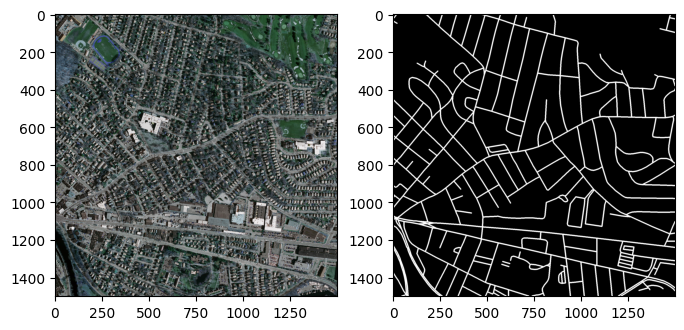

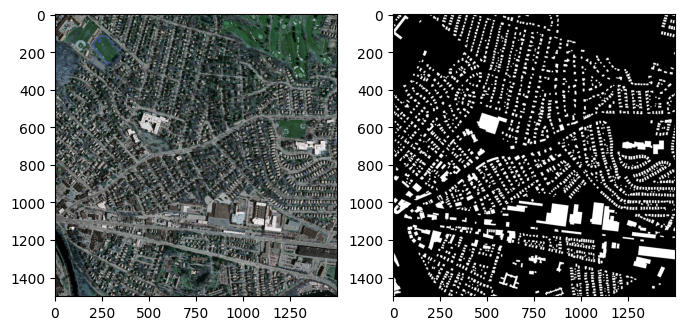

In [ ]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=cv2.imread('../roads_png/train/22679020_15.png')[:,:,:3]
plt.imshow(img)
plt.subplot(1,2,2)
img=cv2.imread('../roads_png/train_labels/22679020_15.png')[:,:,:3]
plt.imshow(img, cmap='gray')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=cv2.imread('../buildings_png/train/22679020_15.png')[:,:,:3]
plt.imshow(img)
plt.subplot(1,2,2)
img=cv2.imread('../buildings_png/train_labels/22679020_15.png')[:,:,:3]
plt.imshow(img, cmap='gray')
plt.show()

# 1.Preprocesado Con cortes

Como las imagenes son muy grandes (1500x1500) hay dos opciones, podemos reducir su tamaño perdiendo resolucion y calidad de imagen pero manteniendo la info espacial o realizar cortes de tamaño deseado manteniendo así la resolucion en pro de perder esa info espacial por corte. Debido al tamaño pequeño de las construcciones, creo que es más importante tener más resolución.

In [3]:
direct='../Img/'

def obtener_corte(img,cut=224,tipo='img'):
    """
    FUNCION:    Obtener cortes de una imagen dada de un tamaño (cutxcut)

    PARAMS:
        img: np.array de la imagen por cv2.imread()
        cut: tamaño del corte
        type: indica si es una imagen o su mascara (msk)

    RETURN:
        array_tot: np.array(numero_cortes,cut,cut,canales) donde canales son 3 en las imagenes
        normales y nada en las mascaras

    """
    # Obtener las dimensiones de la imagen (alto, ancho, canales)
    if tipo == 'img':
        alto, ancho, channels = img.shape
        formato=(1,cut,cut,channels)
    elif tipo == 'msk':
        alto, ancho= img.shape
        formato=(1,cut,cut)

    # Definir las coordenadas para el recorte
    max_val_recorte=alto-cut
    max_val_recorte_x=ancho-cut
    array_tot=np.array([])
    #bucle ene le eje X
    for j in range(1,int(ancho/cut)+2):
        if cut*j<ancho:
            corte_ini_x=cut*(j-1)
            corte_fin_x=cut*j
        else:
            corte_ini_x=max_val_recorte_x
            corte_fin_x=ancho
        #Bucle en el eje Y
        for i in range(1,int(alto/cut)+2):
            if cut*i<alto:
                corte_ini=cut*(i-1)
                corte_fin=cut*i
            else:
                corte_ini=max_val_recorte
                corte_fin=alto
            # Realizar el recorte de la imagen
            if tipo == 'img':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x,:]
            elif tipo == 'msk':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x]
            #agrupar imagenes en un mismo array
            if array_tot.shape[0]>0:
                array_tot=np.vstack([array_tot,trozo_imagen.reshape(formato)])
            else:
                array_tot=trozo_imagen.reshape(formato)
    return array_tot
def num_percentage(img,num=0):
    """
    FUNCION: Devuelve el factor existente entre pixeles de un numero concreto y los pixeles totales de la imagen

    PARAMS:
        img: np.array de la imagen por cv2.imread()

    RETURN:
        num_factor= float pixeles del numero num/ pixeles totales

    """
    total_pixels = img.shape[0] * img.shape[1]
    num_pixels = np.sum(img == num)  # Contar píxeles blancos
    num_factor=num_pixels / total_pixels
    return num_factor

def filter_cut_images_road_build(data_path_images, data_build_path_masks,data_road_path_masks,cut=224, white_threshold=0.1,white_threshold_mask=0.01,limite=0):
    """
    FUNCION: Dados los directorios donde se encuentran imagenes y mascaras, obtener los recortes de cada una de ellas

    PARAMS:
        data_path_images,data_path_masks: path de imagenes y mascaras
        cut: tamaño del corte
        white_threshold: indica el factor maximo de puntos blancos en una imagen
    RETURN:
        white_factor= float pixeles blancos/ pixeles totales
        final_images: np.array(num,cut,cut,3) array con los resultados de los cortes para las imagenes
        final_masks: np.array(num,cut,cut) array con los resultados de los cortes para las mascaras
    """

    data_list_images = os.listdir(data_path_images)
    file_list=[]
    filtered_images = []
    filtered_masks = []

    mask_factors_build=[]
    mask_factors_road=[]

    road_path_discard=0
    build_path_discard=0

    limite = len(data_list_images) if limite == 0 else limite

    for file_name in tqdm(data_list_images[:limite]):
        # Leer la imagen
        img = cv2.imread(os.path.join(data_path_images, file_name))[:,:,:3]
        # Calcular el porcentaje de píxeles blancos
        # Obtener el nombre de la máscara correspondiente
        mask_file_road = os.path.splitext(file_name)[0] + '.png'  # Nombre de la máscara
        mask_path_road = os.path.join(data_road_path_masks, mask_file_road)
        if not os.path.exists(mask_path_road):
            mask_path_road = os.path.join(direct+'roads_png/train_labels', mask_file_road)
        mask_file_build = os.path.splitext(file_name)[0] + '.png'  # Nombre de la máscara
        mask_path_build = os.path.join(data_build_path_masks, mask_file_build)
        if os.path.exists(mask_path_road) and os.path.exists(mask_path_build):
            file_list.append(file_name)
            # Leer mascara
            mask_road = cv2.imread(mask_path_road)[:,:,1]
            mask_build = cv2.imread(mask_path_build)[:,:,1]
            #les cambiamos la numeracion
            mask_build[mask_build==255]=1
            mask_road[mask_road==255]=1
            #añadimos el background
            mask_back=(mask_build+mask_road)*2
            mask_back[mask_back==0]=1
            mask_back[mask_back!=1]=0
            #mask=mask_build+mask_road

            mask=np.concatenate([mask_back.reshape(1500,1500,1),mask_build.reshape(1500,1500,1),mask_road.reshape(1500,1500,1)],axis=2)
            #mask[mask==3]=1#en los casos donde haya carretera y casa primamos la casa
            mask_factors_build.append(num_percentage(mask_build,1))
            mask_factors_road.append(num_percentage(mask_road,1))
            # Obtener cortes
            img_trozos_imagen=obtener_corte(img,cut,tipo='img')
            #agregar a lista
            img_trozos_list=[trozo for trozo in img_trozos_imagen]
            filtered_images+=img_trozos_list
            #obtener cortes de la mascara
            mask_trozos_imagen=obtener_corte(mask,cut,tipo='img')
            #agregar a lista
            mask_trozos_list=[trozo for trozo in mask_trozos_imagen]
            filtered_masks+=mask_trozos_list
        else:
            if os.path.exists(mask_path_road):
                build_path_discard+=1
            else:
                road_path_discard+=1

    print(f'Se han descartado {build_path_discard+road_path_discard} imagenes, {road_path_discard} por road y {build_path_discard} por build')
    # Convertir las listas en arrays NumPy
    filtered_images = np.asarray(filtered_images, dtype=np.uint8)
    filtered_masks = np.asarray(filtered_masks, dtype=np.uint8)

    mask_factors_build =np.array(mask_factors_build)
    mask_factors_road =np.array(mask_factors_road)

    return filtered_images, filtered_masks, mask_factors_build, mask_factors_road

**Nota**: hay que limitar el numero de imagenes, en el entrenamiento se obtienen 36000 cortes, a la hora de hacer el enetrenamiento desde Google Collab se superan por bastante los límites de GPU y CPU

In [ ]:
# Definir las dimensiones de las imágenes#
cut=224
white_threshold = 0.1
white_threshold_mask=0.05
# Directorios de los conjuntos de datos
data_path_train = direct+"buildings_png/train"
data_path_train_mask = direct+"buildings_png/train_labels"
data_path_train_mask_roads = direct+"roads_png/train_labels"

data_path_test = direct+"buildings_png/test"
data_path_test_mask = direct+"buildings_png/test_labels"
data_path_test_roads = direct+"roads_png/test_labels"

data_path_val = direct+"buildings_png/val"
data_path_val_mask = direct+"buildings_png/val_labels"
data_path_val_mask_roads = direct+"roads_png/val_labels"

X_train_pro, Y_train_pro, mask_factors_train_build, mask_factors_train_road = filter_cut_images_road_build(data_path_train, data_path_train_mask,data_path_train_mask_roads, cut=cut, white_threshold=white_threshold
                                                                            ,white_threshold_mask=white_threshold_mask,limite=80)
print('X_train:', X_train_pro.shape)
print('Y_train:', Y_train_pro.shape)

X_test_pro, Y_test_pro, mask_factors_test_build, mask_factors_test_road = filter_cut_images_road_build(data_path_test, data_path_test_mask,data_path_test_roads, cut=cut, white_threshold=white_threshold
                                                                         ,white_threshold_mask=white_threshold_mask,limite=10)
print('X_test:', X_test_pro.shape)
print('Y_test:', Y_test_pro.shape)

X_val_pro, Y_val_pro, mask_factors_val_build, mask_factors_val_road = filter_cut_images_road_build(data_path_val, data_path_val_mask,data_path_val_mask_roads, cut=cut, white_threshold=white_threshold
                                                                      ,white_threshold_mask=white_threshold_mask,limite=5)
print('X_val:', X_val_pro.shape)
print('Y_val:', Y_val_pro.shape)

100%|██████████| 80/80 [00:12<00:00,  6.32it/s]


Se han descartado 6 imagenes, 6 por road y 0 por build
X_train: (3626, 224, 224, 3)
Y_train: (3626, 224, 224, 3)


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Se han descartado 0 imagenes, 0 por road y 0 por build
X_test: (490, 224, 224, 3)
Y_test: (490, 224, 224, 3)


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

Se han descartado 0 imagenes, 0 por road y 0 por build
X_val: (196, 224, 224, 3)
Y_val: (196, 224, 224, 3)


**Nota**: el dataset esta desbalanceado, es decir, el numero de valores positivos (estructuras) detectados en la mascara vs numero de valores negativos no es 50/50. Esto es importante a la hora de evaluar la calidad de los resultados

In [7]:

df_dat=pd.DataFrame({
    'Train_1_build':[mask_factors_train_build.max(),mask_factors_train_build.mean(),mask_factors_train_build.min()],
    'Test_1_build':[mask_factors_test_build.max(),mask_factors_test_build.mean(),mask_factors_test_build.min()],
    'Val_1_build':[mask_factors_val_build.max(),mask_factors_val_build.mean(),mask_factors_val_build.min()],
    'Train_2_road':[mask_factors_train_road.max(),mask_factors_train_road.mean(),mask_factors_train_road.min()],
    'Test_2_road':[mask_factors_test_road.max(),mask_factors_test_road.mean(),mask_factors_test_road.min()],
    'Val_2_road':[mask_factors_val_road.max(),mask_factors_val_road.mean(),mask_factors_val_road.min()],
},index=['Max','Mean','Min'])
print('Factores asociados a Valores positivos/ Total valores')
display(df_dat)
time.sleep(0.1)
print('Precisiones esperadas en función de los valores positivos')
display(1-df_dat)

Factores asociados a Valores positivos/ Total valores


,Train_1_build,Test_1_build,Val_1_build,Train_2_road,Test_2_road,Val_2_road
Max,0.306144,0.356886,0.150586,0.173562,0.196716,0.121374
Mean,0.149772,0.186066,0.108843,0.103495,0.111934,0.078731
Min,0.034359,0.088069,0.059696,0.040624,0.045143,0.036739


Precisiones esperadas en función de los valores positivos


,Train_1_build,Test_1_build,Val_1_build,Train_2_road,Test_2_road,Val_2_road
Max,0.693856,0.643114,0.849414,0.826438,0.803284,0.878626
Mean,0.850228,0.813934,0.891157,0.896505,0.888066,0.921269
Min,0.965641,0.911931,0.940304,0.959376,0.954857,0.963261


Vemos que esperamos precisiones alrededor del 0.86 para las estructuras, clase 1, y de 0.9 para las carreteras, clase 2, en general se esperan precisiones de 0.88 y que evolucionen a valores cercanos de 0.96-97 en entrenamiento y en 0.91-0.95 en test/validacion.

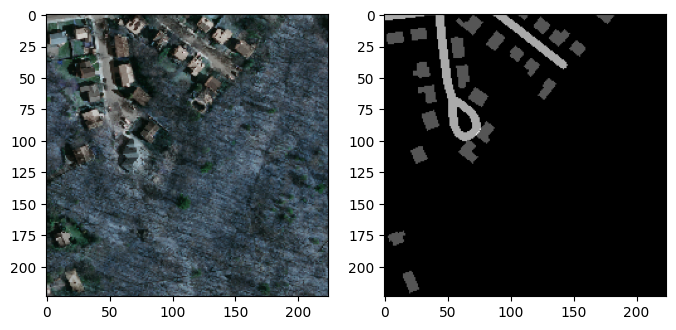

In [ ]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(X_val_pro[m])
plt.subplot(1,2,2)
plt.imshow(Y_val_pro[m][:,:,1]+Y_val_pro[m][:,:,2]*2, cmap='gray')
#plt.imshow(Y_val_pro[m][:,:,2], cmap='gray')
plt.show()

# 2.Entrenamiento

In [8]:
# binary segmentation (this parameters are default when you call Unet('resnet34')
model_pro = sm.Unet('resnet50',input_shape=(224, 224, 3), classes=3, activation='softmax', encoder_weights='imagenet')
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_pro = preprocess_input(X_train_pro)
X_test_pro = preprocess_input(X_test_pro)

model_pro.compile(
    'Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
checkpoint = ModelCheckpoint(filepath='road_build_models/modelo-{epoch:02d}-{val_accuracy:.2f}.weights.h5',
                             monitor='val_accuracy',  # Puede ser 'val_accuracy' si prefieres
                             save_best_only=True,
                             save_weights_only=True,  # Para guardar toda la arquitectura y los pesos
                             mode='max',  # O 'max' si monitorizas 'accuracy'
                             verbose=1)

**Nota:** Debido al alto coste computacional este comando se ha ejecutado desde la GPU de Google Collab, como se ve, ha tardado unos 55min para solo 25 epocas.

In [10]:
start=time.time()
history=model_pro.fit(
   x=X_train_pro,
   y=Y_train_pro.astype(np.float16),
   batch_size=16,
   epochs=20,
   validation_data=(X_test_pro, Y_test_pro.astype(np.float16)),
   callbacks=[checkpoint],
)
print(f'Finalizado en {round(time.time()-start,2)} s')

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7859 - loss: 0.5425
Epoch 1: val_accuracy improved from -inf to 0.79725, saving model to road_build_models/modelo-01-0.80.weights.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 213s 532ms/step - accuracy: 0.7861 - loss: 0.5420 - val_accuracy: 0.7973 - val_loss: 0.5085
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8679 - loss: 0.3345
Epoch 2: val_accuracy improved from 0.79725 to 0.84863, saving model to road_build_models/modelo-02-0.85.weights.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step - accuracy: 0.8680 - loss: 0.3344 - val_accuracy: 0.8486 - val_loss: 0.3873
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8792 - loss: 0.3053
Epoch 3: val_accuracy did not improve from 0.84863
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 275ms/step - accuracy: 0.8792 - loss: 0.3053 - val_accuracy: 0.8358 - val_loss: 0.4118
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8846 - loss: 0.2918
Epoch 4

In [12]:
model_pro.save_weights('road_build_models/model_final.weights.h5')

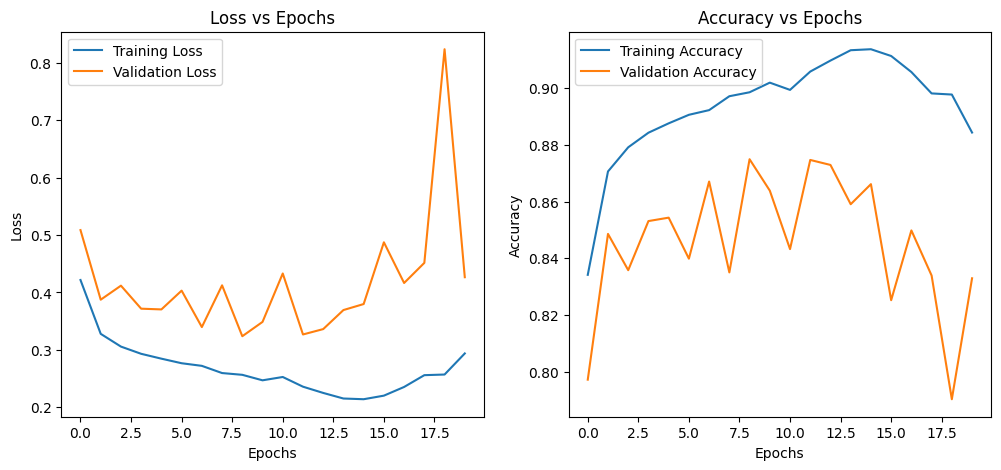

In [13]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación

# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

**Nota:** Se ve como a partir de las 5-10 epocas la función pérdida en validación se estabiliza, además de fluctuar mucho. Algo parecido ocurre con las precisiones aunque con una ligera tendencia ascendente

In [198]:
# Definir el backbone y la arquitectura del modelo sin encoder_weights
BACKBONE = 'resnet50'
model_load = sm.Unet(BACKBONE, classes=3, activation='softmax')
model_load.load_weights('../road_build_models/modelo-07-0.87.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


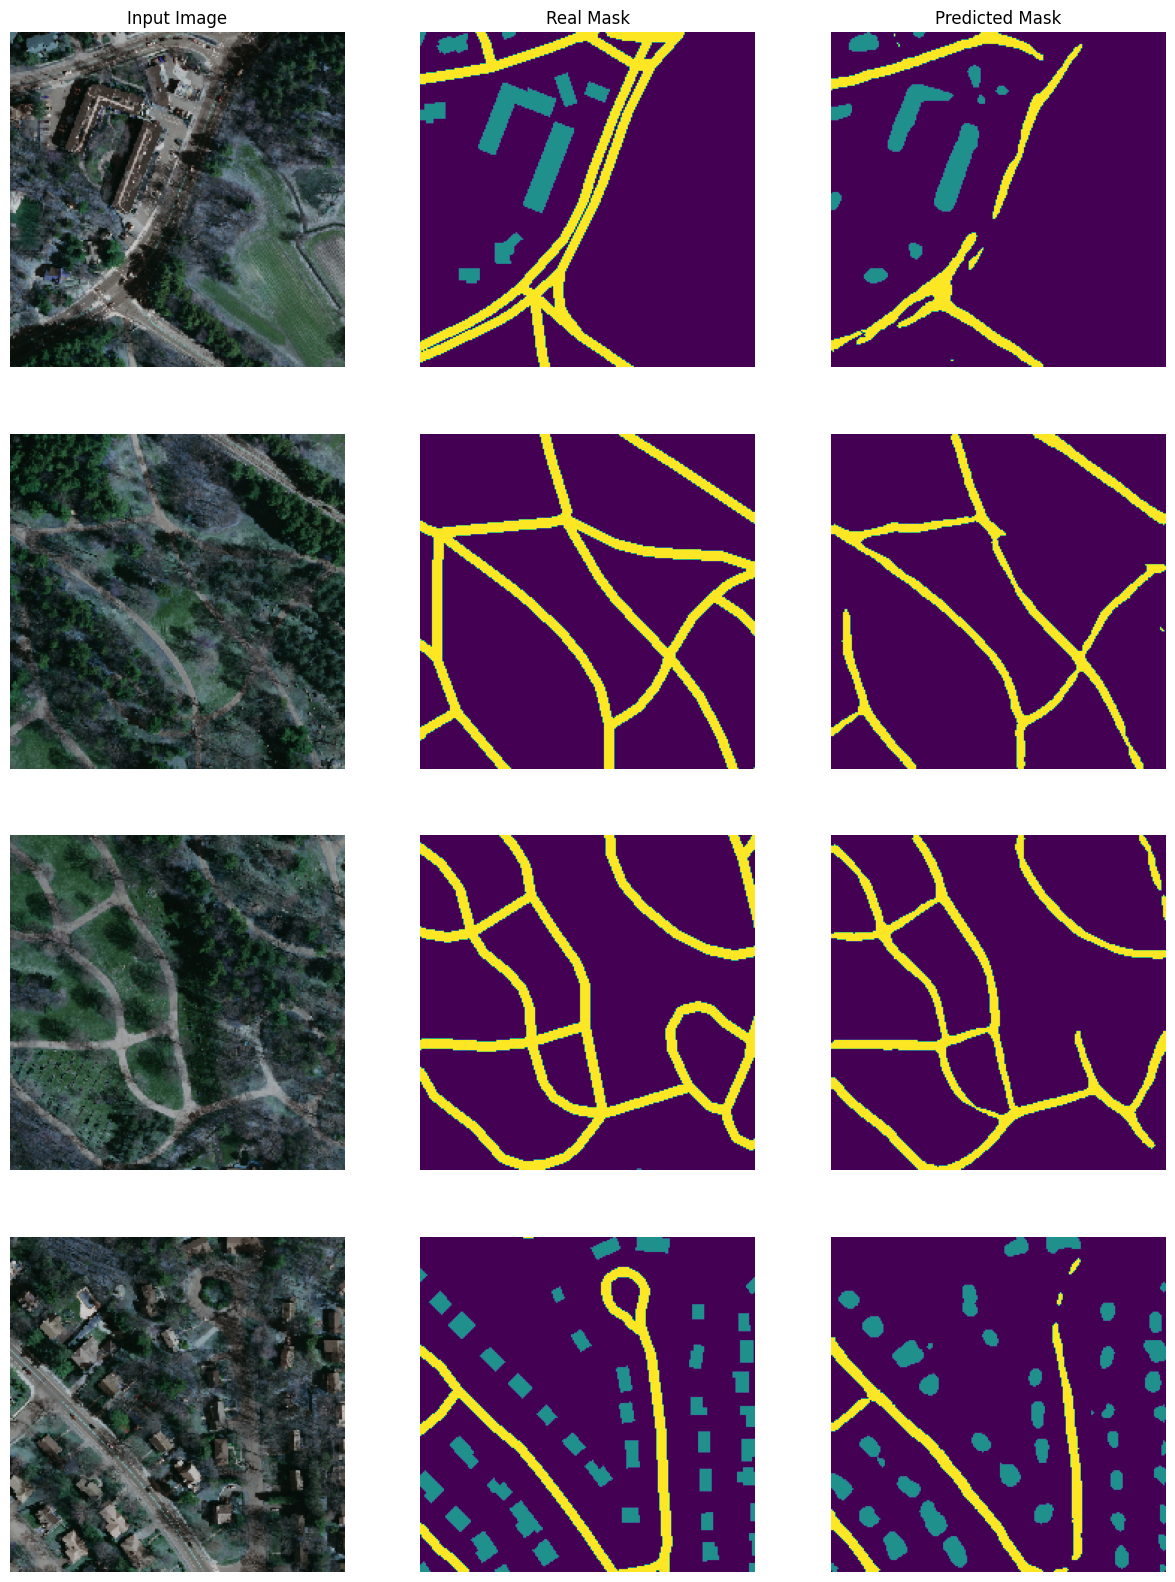

In [210]:
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
max_image=4
# Preparar imágenes y títulos para visualizar en grupos de tres
images_list = []
preds=model_load.predict(X_val_pro[:4])
pred_binary = (preds > 0.5).astype(np.uint8)
# Agrupar imágenes y títulos en filas de tres
for i in range(0, 4):
    input_image = X_val_pro[i]
    ground_truth_mask = Y_val_pro[i][:,:,1]+Y_val_pro[i][:,:,2]*2
    predicted_mask = pred_binary[i][:,:,1]+pred_binary[i][:,:,2]*2
    images_list.append([input_image, ground_truth_mask, predicted_mask])
plot_images_comparation(images_list)


In [215]:
def reconstruir_imagen(trozos_imagen,tamano_original,tipo='img'):
    num_cortes=trozos_imagen.shape[0]
    recorte=trozos_imagen.shape[1]
    num_cortes_eje=int(np.sqrt(num_cortes))
    a=np.array([])
    if tipo == 'img':
        channels=num_cortes=trozos_imagen.shape[3]
        a=np.zeros((tamano_original,tamano_original,channels))
    elif tipo=='msk':
        if len(trozos_imagen.shape)==3:
            a=np.zeros((tamano_original,tamano_original))
        elif len(trozos_imagen.shape)==4:
            a=np.zeros((tamano_original,tamano_original,1))
    index_tot=0
    for i in range(num_cortes_eje):
        if i!=num_cortes_eje-1:
            corte_ini_x=(i)*recorte
            corte_fin_x=(i+1)*recorte
        else:
            corte_ini_x=tamano_original-recorte
            corte_fin_x=tamano_original
        for j in range(num_cortes_eje):
            #if a.shape[0]==0:
            #    a=trozos_imagen[i]
            #else:
            #    a=np.vstack([a,trozos_imagen[i]])
            #print(a.shape,trozos_imagen[i].shape)
            if j!=num_cortes_eje-1:
                corte_ini_y=(j)*recorte
                corte_fin_y=(j+1)*recorte
            else:
                corte_ini_y=tamano_original-recorte
                corte_fin_y=tamano_original
            if tipo == 'img':
                a[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x,:]=trozos_imagen[index_tot]
            elif tipo=='msk':
                if len(trozos_imagen.shape)==3:
                    a[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x]=trozos_imagen[index_tot]
                if len(trozos_imagen.shape)==4:
                    a[corte_ini_y:corte_fin_y,corte_ini_x:corte_fin_x,:]=trozos_imagen[index_tot]

            index_tot+=1
    return a

# Prueba con una imagen cualquiera (Validación)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step


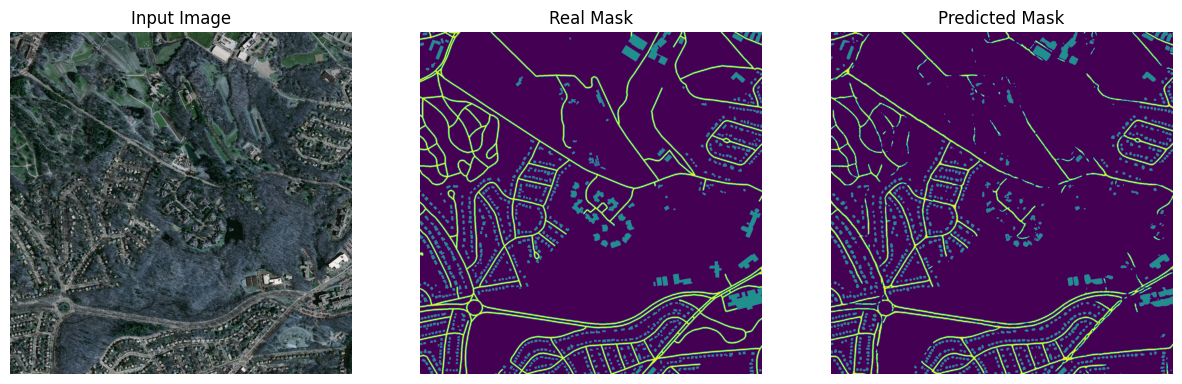

In [249]:
img=cv2.imread(r'..\buildings_png\val\22978945_15.png')[:,:,:3]
img_mask=cv2.imread(r'..\buildings_png\val_labels\22978945_15.png')[:,:,1]
img_mask_road=cv2.imread(r'..\roads_png\train_labels\22978945_15.png')[:,:,1]
#realizar corte
trozos_imagen=obtener_corte(img)
#predicciones
preds=model_load.predict(trozos_imagen)
pred_binary = (preds > 0.5).astype(np.uint8)
#reconstruyo la prediccion
pred_mask_recon=reconstruir_imagen(pred_binary,1500,tipo='img')
# Mostrar las imágenes en filas de tres
mask=(img_mask/255+(img_mask_road/255)*2)
mask[mask==3]=1

pred=pred_mask_recon[:,:,1]+pred_mask_recon[:,:,2]*2
plot_images_comparation([[img,mask,pred]])
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#for j in range(3):
#    axs[j].imshow([img,img_mask,pred_mask_recon][j])
#    axs[j].axis('off')
#    axs[j].set_title(["Input Image", "Ground Truth Mask", "Predicted Mask"][j])
#
#plt.show()


In [252]:
#pred_binary = (preds > 0.5).astype(np.uint8)  # Si pred son probabilidades entre 0 y 1

# Asegúrate de que y_test también esté en el mismo formato
y_test_binary = mask

# Aplanar ambos arrays para calcular la accuracy pixel a pixel
y_test_flat = y_test_binary.flatten()
pred_flat = pred.flatten()

# Calcular la accuracy
accuracy = accuracy_score(y_test_flat, pred_flat)
print(accuracy)

matriz_confusion = confusion_matrix(y_test_flat, pred_flat)

print("Matriz de Confusión:")
print(matriz_confusion)
report = classification_report(y_test_flat, pred_flat)
print(report)

0.9331355555555556
Matriz de Confusión:
[[1897576   22703   22929]
 [  42549   91749      17]
 [  62211      36  110230]]
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96   1943208
         1.0       0.80      0.68      0.74    134315
         2.0       0.83      0.64      0.72    172477

    accuracy                           0.93   2250000
   macro avg       0.86      0.77      0.81   2250000
weighted avg       0.93      0.93      0.93   2250000



Se ve como las precisiones de las clases 1 y 2 estan bien, sin embargo el f1 score es medianamente decente pero el recall es bajo, por lo tanto no predice tan bien esos valores positivos.

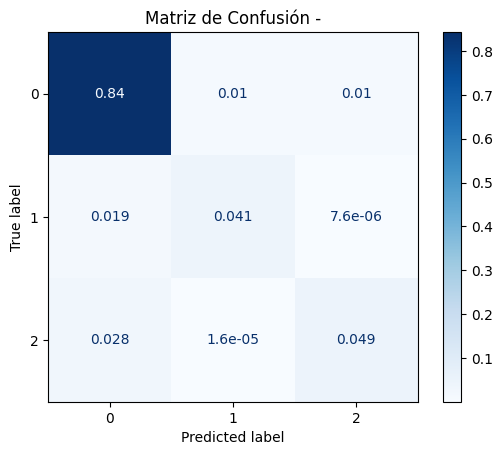

In [253]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

class_names=list(range(matriz_confusion.shape[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion/pred_flat.shape[0], display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
# Añadir título y etiquetas
plt.title("Matriz de Confusión -")
plt.show()

# --------------------